In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [89]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = pd.to_datetime(df_orders.order_date).dt.to_period("m")
df_orders['order_year'] = pd.to_datetime(df_orders.order_date).dt.to_period("y")
df_orders['order_month'] = df_orders['order_month'].astype(str)
df_orders['order_year'] = df_orders['order_year'].astype(str)

In [90]:
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [121]:
df_orders.head()

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
0,100006,9/7/2014,Standard,DK-13375,377.970,2014-09,2014
1,100090,7/8/2014,Standard,EB-13705,699.192,2014-07,2014
2,100293,3/14/2014,Standard,NF-18475,91.056,2014-03,2014
3,100328,1/28/2014,Standard,JC-15340,3.928,2014-01,2014
4,100363,4/8/2014,Standard,JM-15655,21.376,2014-04,2014


In [122]:
df_customers.head()

,customer_id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [93]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')

In [123]:
df_merge.head()

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city
0,100006,9/7/2014,Standard,DK-13375,377.970,2014-09,2014,Dennis Kane,Consumer,Ohio,Marion
1,131884,12/6/2015,Same Day,DK-13375,594.002,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion
2,145065,12/12/2015,First,DK-13375,32.308,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion
3,133046,7/27/2017,Second,DK-13375,297.990,2017-07,2017,Dennis Kane,Consumer,Ohio,Marion
4,165099,12/11/2017,First,DK-13375,1.392,2017-12,2017,Dennis Kane,Consumer,Ohio,Marion


In [95]:
df_first = df_merge.groupby('customer_id')['order_year'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']

In [124]:
df_first.head()

,customer_id,first_order
0,AA-10315,2014
1,AA-10375,2014
2,AA-10480,2014
3,AA-10645,2014
4,AB-10015,2014


In [97]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')

In [125]:
df_full.head()

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
0,100006,9/7/2014,Standard,DK-13375,377.970,2014-09,2014,Dennis Kane,Consumer,Ohio,Marion,2014
1,131884,12/6/2015,Same Day,DK-13375,594.002,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion,2014
2,145065,12/12/2015,First,DK-13375,32.308,2015-12,2015,Dennis Kane,Consumer,Ohio,Marion,2014
3,133046,7/27/2017,Second,DK-13375,297.990,2017-07,2017,Dennis Kane,Consumer,Ohio,Marion,2014
4,165099,12/11/2017,First,DK-13375,1.392,2017-12,2017,Dennis Kane,Consumer,Ohio,Marion,2014


In [99]:
df_users = df_full.groupby(['customer_id', 'first_order', 'order_year'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()

In [100]:
df_users

,customer_id,first_order,order_year,sales,id
0,AA-10315,2014,2014,756.048,2
1,AA-10315,2014,2015,26.960,1
2,AA-10315,2014,2016,4406.072,1
3,AA-10315,2014,2017,374.480,1
4,AA-10375,2014,2014,50.792,2
...,...,...,...,...,...
2494,ZC-21910,2014,2016,3215.733,3
2495,ZC-21910,2014,2017,227.066,4
2496,ZD-21925,2014,2014,244.760,1
2497,ZD-21925,2014,2016,1187.744,3


In [101]:
def get_crosstab(df, value_column):
    df_crosstab = pd.crosstab(df.customer_id, df.order_year, values=df[value_column], aggfunc=sum)\
        .reset_index()
    df_crosstab = pd.merge(df_crosstab, df_first, how='inner', on='customer_id')
    del df_crosstab['customer_id']
    return df_crosstab

In [119]:
def get_retention(df):
    df_triangle = df.groupby(['first_order']).sum().reset_index()
    df_triangle['Base'] = np.diag(df_triangle.iloc[:,1:])
    df_retention = pd.DataFrame(df_triangle[['first_order', 'Base']])
    df_retention.columns = ['Cohort', 'Base']

    for col in df_triangle.columns[1:-1]:
        df_retention[col] = round(df_triangle[col] / df_triangle['Base'], 3)

    for i in range(2, len(df_retention.columns)):
        df_retention.iloc[i-1:, i] = None
        
    return df_retention

### Sales retention

In [120]:
df_sales = get_retention(get_crosstab(df_users, 'sales'))
df_sales

,Cohort,Base,2014,2015,2016,2017
0,2014,484247.4981,1.0,0.754,0.939,1.101
1,2015,105388.4962,NaN,1.000,0.944,1.250
2,2016,54803.6200,NaN,NaN,1.000,1.111
3,2017,7511.8050,NaN,NaN,NaN,1.000


### Transaction retention

In [105]:
df_id = get_retention(get_crosstab(df_users, 'id'))
df_id

,Cohort,Base,2014,2015,2016,2017
0,2014,969.0,1.0,0.833,1.028,1.288
1,2015,231.0,NaN,1.000,0.931,1.268
2,2016,104.0,NaN,NaN,1.000,1.221
3,2017,19.0,NaN,NaN,NaN,1.000


### Sales retention by segment

In [106]:
for segment in df_full.segment.unique():
    print(f'\nSegment: {segment}')
    print(get_retention(get_crosstab(df_full[df_full.segment==segment], 'sales')))


Segment: Consumer
  Cohort         Base  2014   2015   2016   2017
0   2014  266096.8126   1.0  0.789  0.818  0.906
1   2015   56590.8551   NaN  1.000  0.832  0.817
2   2016   32119.4550   NaN    NaN  1.000  1.229
3   2017    4985.0760   NaN    NaN    NaN  1.000

Segment: Corporate
  Cohort         Base  2014   2015   2016   2017
0   2014  128434.8737   1.0  0.778  1.237  1.367
1   2015   28855.5195   NaN  1.000  1.043  1.944
2   2016   18200.6230   NaN    NaN  1.000  0.462
3   2017    1797.0810   NaN    NaN    NaN  1.000

Segment: Home Office
  Cohort        Base  2014   2015   2016   2017
0   2014  89715.8118   1.0  0.616  0.874  1.296
1   2015  19942.1216   NaN  1.000  1.120  1.475
2   2016   4483.5420   NaN    NaN  1.000  2.905
3   2017    729.6480   NaN    NaN    NaN  1.000


### Sales retention by ship_mode

In [107]:
for ship_mode in df_full.ship_mode.unique():
    print(f'\nShip_mode: {ship_mode}')
    print(get_retention(get_crosstab(df_full[df_full.ship_mode==ship_mode], 'sales')))


Ship_mode: Standard
  Cohort         Base  2014   2015   2016   2017
0   2014  305621.3196   1.0  0.716  0.921  0.935
1   2015   65723.8550   NaN  1.000  0.791  1.142
2   2016   38855.4240   NaN    NaN  1.000  0.752
3   2017    5644.8960   NaN    NaN    NaN  1.000

Ship_mode: Same Day
  Cohort       Base  2014   2015   2016   2017
0   2014  17470.134   1.0  1.234  1.759  2.308
1   2015   6050.375   NaN  1.000  0.581  1.136
2   2016    257.040   NaN    NaN  1.000  6.163

Ship_mode: First
  Cohort        Base  2014   2015   2016   2017
0   2014  59769.2645   1.0  0.997  1.010  1.590
1   2015   9644.0606   NaN  1.000  1.632  2.143
2   2016   6153.2850   NaN    NaN  1.000  3.814
3   2017    955.7840   NaN    NaN    NaN  1.000

Ship_mode: Second
  Cohort         Base  2014   2015   2016   2017
0   2014  101386.7800   1.0  0.642  0.811  1.105
1   2015   23970.2056   NaN  1.000  1.180  1.216
2   2016    9537.8710   NaN    NaN  1.000  0.697
3   2017     911.1250   NaN    NaN    NaN  1.000


### Transaction retention by segment

In [108]:
for segment in df_full.segment.unique():
    print(f'\nSegment: {segment}')
    print(get_retention(get_crosstab(df_full[df_full.segment==segment], 'id')))


Segment: Consumer
  Cohort        Base  2014   2015   2016   2017
0   2014  70642071.0   1.0  0.817  0.952  1.253
1   2015  14471087.0   NaN  1.000  0.872  1.214
2   2016   7854869.0   NaN    NaN  1.000  1.192
3   2017   1668887.0   NaN    NaN    NaN  1.000

Segment: Corporate
  Cohort        Base  2014   2015   2016   2017
0   2014  38192114.0   1.0  0.838  1.142  1.277
1   2015   9840039.0   NaN  1.000  0.927  1.301
2   2016   4300655.0   NaN    NaN  1.000  1.029
3   2017    680091.0   NaN    NaN    NaN  1.000

Segment: Home Office
  Cohort        Base  2014   2015   2016   2017
0   2014  21004027.0   1.0  0.923  1.130  1.412
1   2015   6489595.0   NaN  1.000  1.164  1.480
2   2016   1879031.0   NaN    NaN  1.000  1.792
3   2017    113558.0   NaN    NaN    NaN  1.000


### Transaction retention by ship_mode

In [109]:
for ship_mode in df_full.ship_mode.unique():
    print(f'\nShip_mode: {ship_mode}')
    print(get_retention(get_crosstab(df_full[df_full.ship_mode==ship_mode], 'id')))


Ship_mode: Standard
  Cohort        Base  2014   2015   2016   2017
0   2014  78025074.0   1.0  0.853  1.010  1.228
1   2015  18795613.0   NaN  1.000  0.961  1.314
2   2016   8394298.0   NaN    NaN  1.000  1.228
3   2017   1576322.0   NaN    NaN    NaN  1.000

Ship_mode: Same Day
  Cohort       Base  2014   2015   2016   2017
0   2014  6454353.0   1.0  0.882  1.263  1.450
1   2015  1348310.0   NaN  1.000  1.204  1.467
2   2016   250587.0   NaN    NaN  1.000  2.904

Ship_mode: First
  Cohort        Base  2014   2015   2016   2017
0   2014  19568821.0   1.0  0.787  1.113  1.454
1   2015   4075405.0   NaN  1.000  1.239  1.582
2   2016   2395808.0   NaN    NaN  1.000  1.322
3   2017    500026.0   NaN    NaN    NaN  1.000

Ship_mode: Second
  Cohort        Base  2014   2015   2016   2017
0   2014  25789964.0   1.0  0.831  1.002  1.293
1   2015   6581393.0   NaN  1.000  0.695  1.042
2   2016   2993862.0   NaN    NaN  1.000  0.987
3   2017    386188.0   NaN    NaN    NaN  1.000


## Ответ
#### 1. Тотально sales и transaction ретеншены 2017 лучше 2016
#### 2. Но есть слабые когорты, где хуже: 
#### - Для sales-retention это:
    - Segment: Consumer, first order=2015
    - Ship_mode: Standard, first order=2014
    - Ship_mode: Second, first order=2016
#### - Для transaction-retention это:
    - Segment: Consumer, first order=2015
    - Segment: Corporate, first order=2015
    - Ship_mode: Standard, first order=2015
    - Ship_mode: Second, first order=2016
####
### Итого
### Сильно проседают:
### Сегмент Consumer
### Способы доставки Standard, Second

In [128]:
df_new_customers = df_full.groupby('first_order')['id'].count()
df_new_customers.columns = ['first_order', 'id']

<AxesSubplot:xlabel='first_order'>

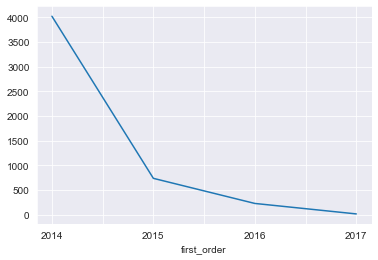

In [129]:
df_new_customers.plot(x='first_order', y='id')